## Montamos el drive de google ya que estamos trabajando en Colab

In [1]:
# Como estamos trabajando en colab y tengo los archivos en el drive importamos la libreria y montamos
from google.colab import drive #para utilizar google drive como fuente de archivos
drive.mount('/content/drive') #montamos la carpeta del drivec

Mounted at /content/drive


## Importamos Librerias necesarias para la lectura del archivo y visualización de datos

In [2]:
import json
import polars as pl
import seaborn as sns
import matplotlib.pyplot as plt

## Leemos el archivo en formato json recorriendo filas, ya que posee columnas con datos anidados.

In [3]:
data_list = []

with open('/content/drive/MyDrive/PF Google & Yelp/1.json', 'r') as file:
    for line in file:
        # Cargar cada objeto JSON por separado
        data = json.loads(line)
        data_list.append(data)

# Ahora data_list es una lista que contiene todos los objetos JSON del archivo
df = pl.DataFrame(data_list)

## Verificamos las columnas para extraer las features.

In [4]:
df.columns

['name',
 'address',
 'gmap_id',
 'description',
 'latitude',
 'longitude',
 'category',
 'avg_rating',
 'num_of_reviews',
 'price',
 'hours',
 'MISC',
 'state',
 'relative_results',
 'url']

## Identificamos las Features:
- 'name' nombre del hotel
- 'gmap_id' identificador unico del lugar, el cual servira como id para futuras merge
- 'latitude' y 'longitude' localización del hotel
- 'category' indica el tipo de establecimiento en este caso nos interesa solo hotel por lo que la utilizaremos para extraer la data.
- 'avg_rating' el promedio de calificaciónes de reseñas de ususarios.
- 'num_of_reviews' cantidad de reseñas.
- 'url' servira para brindar al usuario acceso a la web del hotel.

## Procedemos a eliminar las columnas de menor relevancia para este proyecto.

In [5]:
df = df.drop(['address', 'description', 'price', 'hours', 'MISC', 'state', 'relative_results'])

## Verificamos datos Nulos

In [6]:
df.null_count()

name,gmap_id,latitude,longitude,category,avg_rating,num_of_reviews,url
u32,u32,u32,u32,u32,u32,u32,u32
7,0,0,0,2261,0,0,0


## Existen datos nulos sin embargo, aun no hemos filtrado por hoteles por lo que antes de realizar este paso vamos a extraer los datos.

### Visualizamos los datos del DF

In [7]:
df.head()

name,gmap_id,latitude,longitude,category,avg_rating,num_of_reviews,url
str,str,f64,f64,list[str],f64,i64,str
"""Porter Pharmac…","""0x88f16e41928f…",32.3883,-83.3571,"[""Pharmacy""]",4.9,16,"""https://www.go…"
"""City Textile""","""0x80c2c98c0e3c…",34.018891,-118.21529,"[""Textile exporter""]",4.5,6,"""https://www.go…"
"""San Soo Dang""","""0x80c2c778e3b7…",34.058092,-118.29213,"[""Korean restaurant""]",4.4,18,"""https://www.go…"
"""Nova Fabrics""","""0x80c2c89923b2…",34.023669,-118.23293,"[""Fabric store""]",3.3,6,"""https://www.go…"
"""Nobel Textile …","""0x80c2c632f933…",34.036694,-118.249421,"[""Fabric store""]",4.3,7,"""https://www.go…"


### La columna 'category' es del tipo lista por lo que la expandiremos para su mejor tratamiento

In [8]:

df = df.explode('category')

In [9]:
df.head()

name,gmap_id,latitude,longitude,category,avg_rating,num_of_reviews,url
str,str,f64,f64,str,f64,i64,str
"""Porter Pharmac…","""0x88f16e41928f…",32.3883,-83.3571,"""Pharmacy""",4.9,16,"""https://www.go…"
"""City Textile""","""0x80c2c98c0e3c…",34.018891,-118.21529,"""Textile export…",4.5,6,"""https://www.go…"
"""San Soo Dang""","""0x80c2c778e3b7…",34.058092,-118.29213,"""Korean restaur…",4.4,18,"""https://www.go…"
"""Nova Fabrics""","""0x80c2c89923b2…",34.023669,-118.23293,"""Fabric store""",3.3,6,"""https://www.go…"
"""Nobel Textile …","""0x80c2c632f933…",34.036694,-118.249421,"""Fabric store""",4.3,7,"""https://www.go…"


## Ahora si procedemos a filtrar la categoria de interes

In [10]:
df = df.filter(df['category'].str.contains(f'(?i)hotel'))

In [11]:
df.head()

name,gmap_id,latitude,longitude,category,avg_rating,num_of_reviews,url
str,str,f64,f64,str,f64,i64,str
"""Basecamp Guest…","""0x54907fca2751…",47.471332,-121.686928,"""Hotel""",5.0,8,"""https://www.go…"
"""Sugar River Lo…","""0x88062b28cb53…",42.619862,-89.37789,"""Hotel""",4.7,8,"""https://www.go…"
"""Meraki Lodge""","""0x549b9d4ad8f1…",47.887652,-120.120376,"""Hotel""",4.9,15,"""https://www.go…"
"""View House at …","""0x549b9db4d736…",47.888291,-120.12412,"""Hotel""",4.4,8,"""https://www.go…"
"""Station Lakefr…","""0x4d55cee0af10…",45.99872,-89.490867,"""Resort hotel""",4.7,3,"""https://www.go…"


## Con el DF filtrado procedemos a verificar datos nulos

In [12]:
df.null_count()

name,gmap_id,latitude,longitude,category,avg_rating,num_of_reviews,url
u32,u32,u32,u32,u32,u32,u32,u32
0,0,0,0,0,0,0,0


## Libre de datos nulos procedemos a verificar datos duplicados

In [13]:
df.filter(df.is_duplicated())

name,gmap_id,latitude,longitude,category,avg_rating,num_of_reviews,url
str,str,f64,f64,str,f64,i64,str
"""Basecamp Guest…","""0x54907fca2751…",47.471332,-121.686928,"""Hotel""",5.0,8,"""https://www.go…"
"""Sugar River Lo…","""0x88062b28cb53…",42.619862,-89.37789,"""Hotel""",4.7,8,"""https://www.go…"
"""Meraki Lodge""","""0x549b9d4ad8f1…",47.887652,-120.120376,"""Hotel""",4.9,15,"""https://www.go…"
"""View House at …","""0x549b9db4d736…",47.888291,-120.12412,"""Hotel""",4.4,8,"""https://www.go…"
"""Station Lakefr…","""0x4d55cee0af10…",45.99872,-89.490867,"""Resort hotel""",4.7,3,"""https://www.go…"
"""Kings Island R…","""0x8840f7fb0543…",39.355061,-84.264094,"""Hotel""",2.8,28,"""https://www.go…"
"""Kings Island R…","""0x8840f7fb0543…",39.355061,-84.264094,"""Resort hotel""",2.8,28,"""https://www.go…"
"""Garden City, S…","""0x890040a32810…",33.592541,-79.009323,"""Hotel""",3.0,2,"""https://www.go…"
"""Garden City Ka…","""0x8709f120d869…",38.050028,-100.847887,"""Hotel""",4.3,8,"""https://www.go…"


## Notamos una gran cantidad de elementos duplicados por lo que procedemos a eliminarlos

In [14]:
df = df.unique(subset=['gmap_id'], keep='first')

In [15]:
df.select(pl.all().count())

name,gmap_id,latitude,longitude,category,avg_rating,num_of_reviews,url
u32,u32,u32,u32,u32,u32,u32,u32
675,675,675,675,675,675,675,675


## Verificamos Outliers

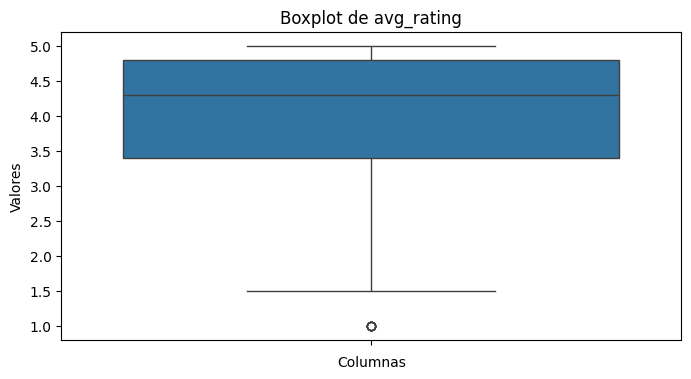

In [16]:
plt.figure(figsize=(8, 4))
sns.boxplot(data=df['avg_rating'])
plt.title('Boxplot de avg_rating')
plt.xlabel('Columnas')
plt.ylabel('Valores')
plt.show()

### notamos que si existen outliers, es referente a la calificación de los hoteles exista un minimo con calificación 1 o cerca de 1 veremos la distribución mediante un histograma

In [25]:
df2=df.group_by('avg_rating').count()

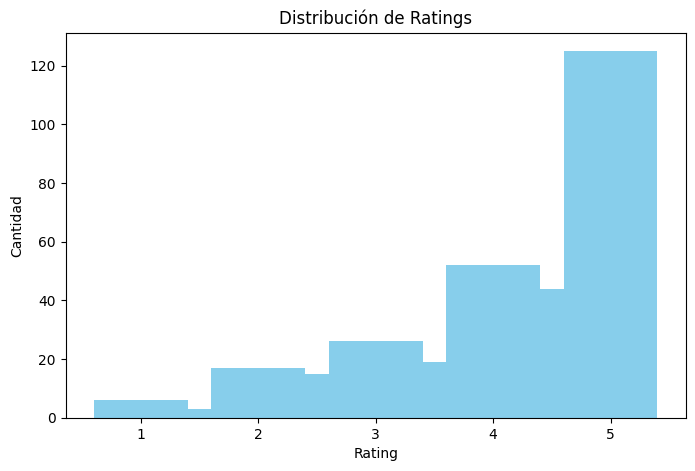

In [38]:
plt.figure(figsize=(8, 5))
plt.bar(df2['avg_rating'], df2['count'], color='skyblue')
plt.xlabel('Rating')
plt.ylabel('Cantidad')
plt.title('Distribución de Ratings')
plt.show()

In [52]:
x=df2.filter(pl.col('avg_rating')<2).select(pl.col('avg_rating').count())/df.height

In [56]:
round(x['avg_rating'][0]*100,2)

0.89

## Son 6 los hoteles que cuentan con datos atipicos que corresponden a menos del 1%

## Ahora obtenemos los outliers para 'num_of_reviews'

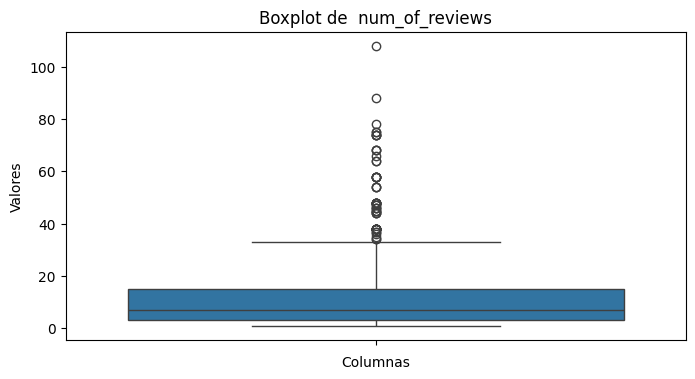

In [57]:
plt.figure(figsize=(8, 4))
sns.boxplot(data=df[ 'num_of_reviews'])
plt.title('Boxplot de  num_of_reviews')
plt.xlabel('Columnas')
plt.ylabel('Valores')
plt.show()

### La gran mayoria de hoteles cuenta con menos de 20 reseñas, podemos observar una gran cantidad de hoteles con valores atipicos muy superiores al 3° cuartil, este no indica que haya que tratar ya que se debe a la capacidad y popularidad de ciertos hoteles los cuales reciben mayor cantidad de comentarios

## Pasemos a ver la distribución de estos datos

In [58]:
df3=df.group_by('num_of_reviews').count()

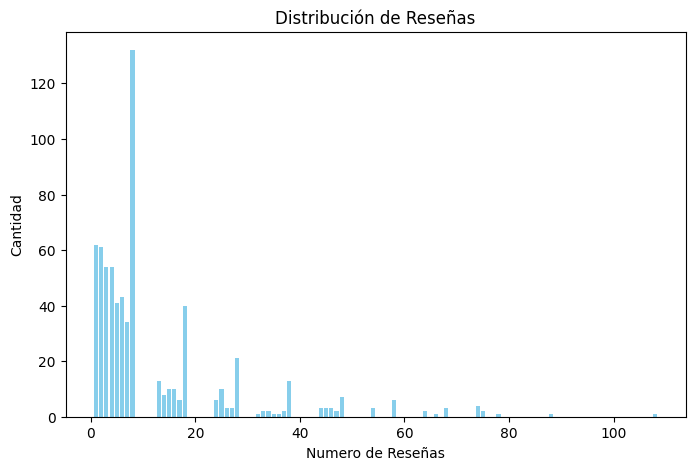

In [60]:
plt.figure(figsize=(8, 5))
plt.bar(df3['num_of_reviews'], df3['count'], color='skyblue')
plt.xlabel('Numero de Reseñas')
plt.ylabel('Cantidad')
plt.title('Distribución de Reseñas')
plt.show()

### Confirmamos lo dicho anteriormente